In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)
data_df['sbj'] += 1

data_df = data_df[data_df['sbj']<4]

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.05)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(3589, 4) (190, 4)


In [6]:
def fpt(t, b, v):
    return b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 21        
                                                                 
Total params: 314 (1.23 KB)
Trainable params: 314 (1.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 71ms/step - loss: 7470.8247
Epoch 2/1000
1/1 [==============================] - 0s 34ms/step - loss: 7467.1851
Epoch 3/1000
1/1 [==============================] - 0s 36ms/step - loss: 7463.5283
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 7459.9043
Epoch 5/1000
1/1 [==============================] - 0s 31ms/step - loss: 7456.2578
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 7452.6504
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 7449.0215
Epoch 8/1000
1/1 [==============================] - 0s 32ms/step - loss: 7445.4316
Epoch 9/1000
1/1 [==============================] - 0s 32ms/step - loss: 7441.8169
Epoch 10/1000
1/1 [==============================] - 0s 38ms/step - loss: 7438.2432
Epoch 11/1000
1/1 [==============================] - 0s 32ms/step - loss: 7434.6392
Epoch 12/1000
1/1 [==============================] - 0s 31ms/step - loss: 7431.0825
E

1/1 [==============================] - 0s 33ms/step - loss: 7150.6948
Epoch 99/1000
1/1 [==============================] - 0s 32ms/step - loss: 7147.6699
Epoch 100/1000
1/1 [==============================] - 0s 32ms/step - loss: 7144.7446
Epoch 101/1000
1/1 [==============================] - 0s 32ms/step - loss: 7141.7266
Epoch 102/1000
1/1 [==============================] - 0s 32ms/step - loss: 7138.8032
Epoch 103/1000
1/1 [==============================] - 0s 31ms/step - loss: 7135.8154
Epoch 104/1000
1/1 [==============================] - 0s 31ms/step - loss: 7132.9160
Epoch 105/1000
1/1 [==============================] - 0s 32ms/step - loss: 7129.9688
Epoch 106/1000
1/1 [==============================] - 0s 32ms/step - loss: 7127.0918
Epoch 107/1000
1/1 [==============================] - 0s 32ms/step - loss: 7124.1382
Epoch 108/1000
1/1 [==============================] - 0s 33ms/step - loss: 7121.2241
Epoch 109/1000
1/1 [==============================] - 0s 32ms/step - loss: 7118.2

1/1 [==============================] - 0s 33ms/step - loss: 6882.5020
Epoch 195/1000
1/1 [==============================] - 0s 33ms/step - loss: 6879.7749
Epoch 196/1000
1/1 [==============================] - 0s 32ms/step - loss: 6877.2939
Epoch 197/1000
1/1 [==============================] - 0s 32ms/step - loss: 6874.6177
Epoch 198/1000
1/1 [==============================] - 0s 33ms/step - loss: 6872.1987
Epoch 199/1000
1/1 [==============================] - 0s 33ms/step - loss: 6869.6079
Epoch 200/1000
1/1 [==============================] - 0s 32ms/step - loss: 6867.1865
Epoch 201/1000
1/1 [==============================] - 0s 32ms/step - loss: 6864.4966
Epoch 202/1000
1/1 [==============================] - 0s 32ms/step - loss: 6861.9878
Epoch 203/1000
1/1 [==============================] - 0s 32ms/step - loss: 6859.2783
Epoch 204/1000
1/1 [==============================] - 0s 32ms/step - loss: 6856.8013
Epoch 205/1000
1/1 [==============================] - 0s 31ms/step - loss: 6854.

1/1 [==============================] - 0s 32ms/step - loss: 6646.7007
Epoch 291/1000
1/1 [==============================] - 0s 33ms/step - loss: 6644.7939
Epoch 292/1000
1/1 [==============================] - 0s 32ms/step - loss: 6643.1162
Epoch 293/1000
1/1 [==============================] - 0s 32ms/step - loss: 6641.5376
Epoch 294/1000
1/1 [==============================] - 0s 32ms/step - loss: 6640.0962
Epoch 295/1000
1/1 [==============================] - 0s 32ms/step - loss: 6638.2407
Epoch 296/1000
1/1 [==============================] - 0s 33ms/step - loss: 6636.5405
Epoch 297/1000
1/1 [==============================] - 0s 33ms/step - loss: 6634.0605
Epoch 298/1000
1/1 [==============================] - 0s 32ms/step - loss: 6631.8486
Epoch 299/1000
1/1 [==============================] - 0s 33ms/step - loss: 6629.2778
Epoch 300/1000
1/1 [==============================] - 0s 33ms/step - loss: 6627.1021
Epoch 301/1000
1/1 [==============================] - 0s 97ms/step - loss: 6624.

1/1 [==============================] - 0s 33ms/step - loss: 6480.9146
Epoch 387/1000
1/1 [==============================] - 0s 32ms/step - loss: 6478.6221
Epoch 388/1000
1/1 [==============================] - 0s 33ms/step - loss: 6476.5952
Epoch 389/1000
1/1 [==============================] - 0s 32ms/step - loss: 6474.6665
Epoch 390/1000
1/1 [==============================] - 0s 32ms/step - loss: 6472.9531
Epoch 391/1000
1/1 [==============================] - 0s 32ms/step - loss: 6471.0942
Epoch 392/1000
1/1 [==============================] - 0s 32ms/step - loss: 6469.7466
Epoch 393/1000
1/1 [==============================] - 0s 33ms/step - loss: 6468.3936
Epoch 394/1000
1/1 [==============================] - 0s 33ms/step - loss: 6467.4399
Epoch 395/1000
1/1 [==============================] - 0s 33ms/step - loss: 6466.5918
Epoch 396/1000
1/1 [==============================] - 0s 33ms/step - loss: 6466.7720
Epoch 397/1000
1/1 [==============================] - 0s 33ms/step - loss: 6466.

1/1 [==============================] - 0s 35ms/step - loss: 6366.2607
Epoch 483/1000
1/1 [==============================] - 0s 35ms/step - loss: 6363.7349
Epoch 484/1000
1/1 [==============================] - 0s 33ms/step - loss: 6362.2891
Epoch 485/1000
1/1 [==============================] - 0s 34ms/step - loss: 6361.1016
Epoch 486/1000
1/1 [==============================] - 0s 35ms/step - loss: 6360.9219
Epoch 487/1000
1/1 [==============================] - 0s 35ms/step - loss: 6361.0132
Epoch 488/1000
1/1 [==============================] - 0s 32ms/step - loss: 6360.9238
Epoch 489/1000
1/1 [==============================] - 0s 32ms/step - loss: 6360.6802
Epoch 490/1000
1/1 [==============================] - 0s 33ms/step - loss: 6361.6777
Epoch 491/1000
1/1 [==============================] - 0s 32ms/step - loss: 6359.4810
Epoch 492/1000
1/1 [==============================] - 0s 33ms/step - loss: 6357.5015
Epoch 493/1000
1/1 [==============================] - 0s 33ms/step - loss: 6355.

1/1 [==============================] - 0s 31ms/step - loss: 6286.0601
Epoch 579/1000
1/1 [==============================] - 0s 31ms/step - loss: 6288.0342
Epoch 580/1000
1/1 [==============================] - 0s 32ms/step - loss: 6288.2368
Epoch 581/1000
1/1 [==============================] - 0s 31ms/step - loss: 6282.6533
Epoch 582/1000
1/1 [==============================] - 0s 31ms/step - loss: 6281.7700
Epoch 583/1000
1/1 [==============================] - 0s 31ms/step - loss: 6279.9136
Epoch 584/1000
1/1 [==============================] - 0s 35ms/step - loss: 6277.2402
Epoch 585/1000
1/1 [==============================] - 0s 34ms/step - loss: 6277.7266
Epoch 586/1000
1/1 [==============================] - 0s 33ms/step - loss: 6276.9365
Epoch 587/1000
1/1 [==============================] - 0s 32ms/step - loss: 6279.8643
Epoch 588/1000
1/1 [==============================] - 0s 32ms/step - loss: 6280.7412
Epoch 589/1000
1/1 [==============================] - 0s 31ms/step - loss: 6286.

1/1 [==============================] - 0s 31ms/step - loss: 6235.9849
Epoch 676/1000
1/1 [==============================] - 0s 31ms/step - loss: 6232.1631
Epoch 677/1000
1/1 [==============================] - 0s 32ms/step - loss: 6231.8813
Epoch 678/1000
1/1 [==============================] - 0s 31ms/step - loss: 6229.1890
Epoch 679/1000
1/1 [==============================] - 0s 32ms/step - loss: 6228.1309
Epoch 680/1000
1/1 [==============================] - 0s 32ms/step - loss: 6229.4507
Epoch 681/1000
1/1 [==============================] - 0s 31ms/step - loss: 6231.0425
Epoch 682/1000
1/1 [==============================] - 0s 31ms/step - loss: 6225.9385
Epoch 683/1000
1/1 [==============================] - 0s 31ms/step - loss: 6228.7012
Epoch 684/1000
1/1 [==============================] - 0s 34ms/step - loss: nan
Epoch 685/1000
1/1 [==============================] - 0s 32ms/step - loss: 6227.4165
Epoch 686/1000
1/1 [==============================] - 0s 31ms/step - loss: 6227.7451
E

1/1 [==============================] - 0s 34ms/step - loss: 6191.6147
Epoch 773/1000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 774/1000
1/1 [==============================] - 0s 31ms/step - loss: 6249.1118
Epoch 775/1000
1/1 [==============================] - 0s 31ms/step - loss: 6194.3442
Epoch 776/1000
1/1 [==============================] - 0s 31ms/step - loss: 6187.2412
Epoch 777/1000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 778/1000
1/1 [==============================] - 0s 31ms/step - loss: 6199.5415
Epoch 779/1000
1/1 [==============================] - 0s 31ms/step - loss: 6189.4126
Epoch 780/1000
1/1 [==============================] - 0s 38ms/step - loss: 6193.0146
Epoch 781/1000
1/1 [==============================] - 0s 43ms/step - loss: 6241.3481
Epoch 782/1000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 783/1000
1/1 [==============================] - 0s 31ms/step - loss: 6183.7070
Epoch 784/100

1/1 [==============================] - 0s 32ms/step - loss: 6178.2778
Epoch 871/1000
1/1 [==============================] - 0s 33ms/step - loss: 6159.0181
Epoch 872/1000
1/1 [==============================] - 0s 32ms/step - loss: 6154.1812
Epoch 873/1000
1/1 [==============================] - 0s 32ms/step - loss: 6148.8550
Epoch 874/1000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 875/1000
1/1 [==============================] - 0s 32ms/step - loss: 6148.9121
Epoch 876/1000
1/1 [==============================] - 0s 32ms/step - loss: 6176.0186
Epoch 877/1000
1/1 [==============================] - 0s 32ms/step - loss: 6156.9136
Epoch 878/1000
1/1 [==============================] - 0s 32ms/step - loss: 6148.3911
Epoch 879/1000
1/1 [==============================] - 0s 32ms/step - loss: 6144.0654
Epoch 880/1000
1/1 [==============================] - 0s 36ms/step - loss: 6144.0327
Epoch 881/1000
1/1 [==============================] - 0s 35ms/step - loss: 6145.6157
E

1/1 [==============================] - 0s 33ms/step - loss: 6111.2759
Epoch 969/1000
1/1 [==============================] - 0s 34ms/step - loss: nan
Epoch 970/1000
1/1 [==============================] - 0s 34ms/step - loss: 6122.8662
Epoch 971/1000
1/1 [==============================] - 0s 32ms/step - loss: 6109.5254
Epoch 972/1000
1/1 [==============================] - 0s 34ms/step - loss: 6104.4800
Epoch 973/1000
1/1 [==============================] - 0s 33ms/step - loss: 6104.6240
Epoch 974/1000
1/1 [==============================] - 0s 32ms/step - loss: nan
Epoch 975/1000
1/1 [==============================] - 0s 33ms/step - loss: 6139.3140
Epoch 976/1000
1/1 [==============================] - 0s 33ms/step - loss: nan
Epoch 977/1000
1/1 [==============================] - 0s 31ms/step - loss: 6104.2896
Epoch 978/1000
1/1 [==============================] - 0s 32ms/step - loss: 6102.8389
Epoch 979/1000
1/1 [==============================] - 0s 33ms/step - loss: 6102.5483
Epoch 980/100

In [19]:
pred_v_train = model.predict(X_train)
pred_v_test = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

6/6 [==============================] - 0s 463us/step


In [20]:
pred_bhv_train = {'sbj': [],
                  'rt': [],
                  'ch': []}

pred_bhv_test = {'sbj': [],
                  'rt': [],
                  'ch': []}

for n in range(10):
    for s in range(tr_df.shape[0]):
        rt, ch = Race(pred_v_train[s,:], threshold[tr_df.sbj[s]-1], ndt[tr_df.sbj[s]-1])
        pred_bhv_train['sbj'].append(tr_df.sbj[s])
        pred_bhv_train['rt'].append(rt)
        pred_bhv_train['ch'].append(ch)
        
for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv_test['sbj'].append(ts_df.sbj[s])
        pred_bhv_test['rt'].append(rt)
        pred_bhv_test['ch'].append(ch)
        
pred_bhv_train = pd.DataFrame(pred_bhv_train)
pred_bhv_test = pd.DataFrame(pred_bhv_test)

PearsonRResult(statistic=-0.6033323220002725, pvalue=0.5876785301511231)
-0.2651731034624287
0.1044830869903373
PearsonRResult(statistic=0.7592686907239862, pvalue=0.4511136708042902)
0.1607215553179424
0.002650125057739146


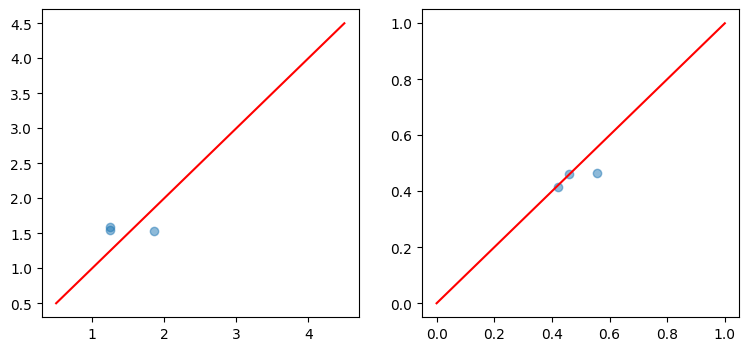

In [21]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
pearsonr
print(pearsonr(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_test.groupby(by='sbj')['rt'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_test.groupby(by='sbj')['rt'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_test.groupby(by='sbj')['rt'].mean()))

plt.plot(np.linspace(0.5, 4.5, 100), np.linspace(0.5, 4.5, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['rt'].mean(),
            pred_bhv_test.groupby(by='sbj')['rt'].mean(), alpha=0.5);

plt.subplot(122)
print(pearsonr(ts_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_test.groupby(by='sbj')['ch'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_test.groupby(by='sbj')['ch'].mean()))
print(mean_squared_error(ts_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_test.groupby(by='sbj')['ch'].mean()))

plt.plot(np.linspace(0., 1, 100), np.linspace(0., 1, 100), c='red')
plt.scatter(ts_df.groupby(by='sbj')['choice'].mean(),
            pred_bhv_test.groupby(by='sbj')['ch'].mean(), alpha=0.5);

PearsonRResult(statistic=-0.5094567759267319, pvalue=0.6596927485292706)
-0.3332608954679186
0.1044325188848463
PearsonRResult(statistic=-0.9588150334946547, pvalue=0.18334387115737766)
-0.25718950998472434
0.0008013825690918634


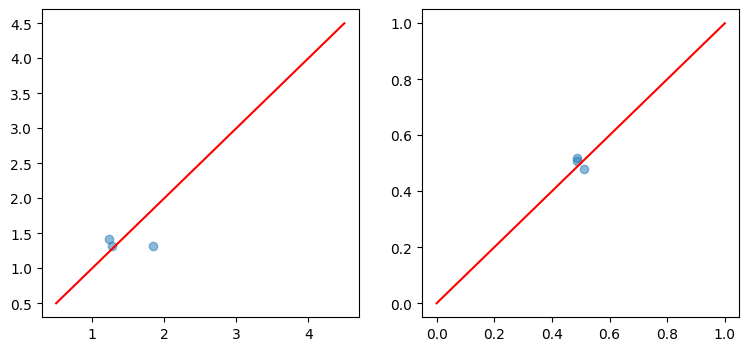

In [22]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
pearsonr
print(pearsonr(tr_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_train.groupby(by='sbj')['rt'].mean()))
print(r2_score(tr_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_train.groupby(by='sbj')['rt'].mean()))
print(mean_squared_error(tr_df.groupby(by='sbj')['rt'].mean(),
               pred_bhv_train.groupby(by='sbj')['rt'].mean()))

plt.plot(np.linspace(0.5, 4.5, 100), np.linspace(0.5, 4.5, 100), c='red')
plt.scatter(tr_df.groupby(by='sbj')['rt'].mean(),
            pred_bhv_train.groupby(by='sbj')['rt'].mean(), alpha=0.5);

plt.subplot(122)
print(pearsonr(tr_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_train.groupby(by='sbj')['ch'].mean()))
print(r2_score(ts_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_train.groupby(by='sbj')['ch'].mean()))
print(mean_squared_error(tr_df.groupby(by='sbj')['choice'].mean(),
               pred_bhv_train.groupby(by='sbj')['ch'].mean()))

plt.plot(np.linspace(0., 1, 100), np.linspace(0., 1, 100), c='red')
plt.scatter(tr_df.groupby(by='sbj')['choice'].mean(),
            pred_bhv_train.groupby(by='sbj')['ch'].mean(), alpha=0.5);

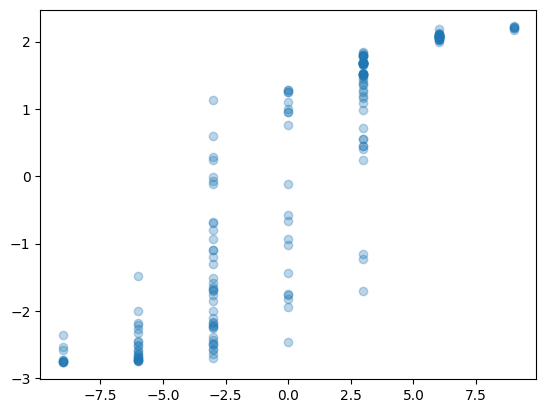

In [23]:
plt.scatter(X_test[:, 0] - X_test[:, 1], pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

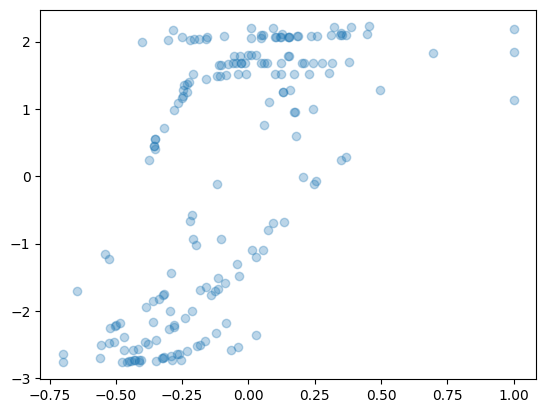

In [24]:
plt.scatter(X_test[:, 2] - X_test[:, 3], pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

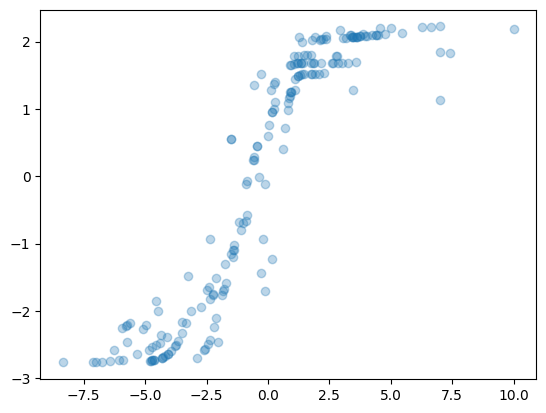

In [25]:
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

In [ ]:
# plt.scatter(X[:, 0] - X[:, 1], pred[:, 0] - pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 2] - X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3)
# plt.scatter(X[:, 0]*X[:, 2] - X[:, 1]*X[:, 3], pred[:, 0] - pred[:, 1], alpha=0.3);


#         if ts_df['item_value_0'][s] > ts_df['item_value_1'][s] and ch == 0:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_1'][s] > ts_df['item_value_0'][s] and ch == 1:
#             pred_bhv['ch'].append(1)
#         elif ts_df['item_value_1'][s] == ts_df['item_value_0'][s]:
#             pred_bhv['ch'].append(1)
#         else:
#             pred_bhv['ch'].append(0)

# high = ((ts_df['item_value_1'] >= ts_df['item_value_0']).map({True:1, 
#                                                               False:0}) == ts_df['choice']).map({True:1, 
#                                                                                                  False:0})
# high[ts_df['item_value_1'] == ts_df['item_value_0']] = 1
# ts_df['is_high'] = high 